In [132]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re, string, unicodedata
from bs4 import BeautifulSoup

import nltk

nltk.download('wordnet')
nltk.download('punkt')

from nltk.tokenize import word_tokenize 
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import SMOTE

**Load dataset**

In [59]:
# Load the dataset
tweets = pd.read_csv('Tweets.csv',header=0)

In [60]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**Shape of Data**

In [61]:
print(tweets.shape)

(14640, 15)


In [62]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [63]:
tweets.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [64]:
tweets['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

**Checking for duplicate data**

In [65]:
duplicateRows = tweets[tweets.duplicated()]

print(duplicateRows.shape) 

(36, 15)


In [66]:
duplicateRows.head(36)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
12040,570308309682675712,negative,1.0,Customer Service Issue,1.0,American,NaN,SweeLoTmac,NaN,0,@AmericanAir why would I even consider continu...,NaN,2015-02-24 11:44:31 -0800,NaN,Quito
12059,570305051819941889,neutral,1.0,NaN,NaN,American,NaN,Chandrafaythe,NaN,0,@AmericanAir my flight got Cancelled Flightled...,NaN,2015-02-24 11:31:34 -0800,NaN,Quito
12063,570303383782989824,neutral,1.0,NaN,NaN,American,NaN,trentgillaspie,NaN,0,.@AmericanAir just disappointed with the Fligh...,NaN,2015-02-24 11:24:57 -0800,"Austin, but often Denver",Mountain Time (US & Canada)
12066,570301929580048385,neutral,1.0,NaN,NaN,American,NaN,FinEdChat,NaN,0,@AmericanAir I did,NaN,2015-02-24 11:19:10 -0800,"Cincinnati, Ohio",Atlantic Time (Canada)
12068,570301395141836801,negative,1.0,Late Flight,1.0,American,NaN,JoBarredaV,NaN,1,@AmericanAir r u serious?? 304min #delay with ...,NaN,2015-02-24 11:17:02 -0800,Mexico City,Central Time (US & Canada)
12069,570300915418320897,negative,1.0,Cancelled Flight,1.0,American,NaN,LancasterPattie,NaN,0,@AmericanAir You are jumping the gun and Cance...,NaN,2015-02-24 11:15:08 -0800,NaN,NaN
12074,570299252141903873,positive,1.0,NaN,NaN,American,NaN,Mtts28,NaN,0,@AmericanAir This is exactly why ill be flying...,NaN,2015-02-24 11:08:32 -0800,Virginia,Eastern Time (US & Canada)
12075,570298770136674304,negative,1.0,Customer Service Issue,1.0,American,NaN,law_econ,NaN,0,@AmericanAir This doesn't address my issue. I ...,NaN,2015-02-24 11:06:37 -0800,"Newport Beach, CA",Central Time (US & Canada)
12078,570298644475346945,negative,1.0,Customer Service Issue,1.0,American,NaN,denismishin,NaN,0,@AmericanAir submitted a case to AA customer r...,NaN,2015-02-24 11:06:07 -0800,"Bellevue, WA",Eastern Time (US & Canada)
12079,570298371140939776,negative,1.0,Late Flight,1.0,American,NaN,djjohnpayne,NaN,0,@AmericanAir if by near the gate you mean sitt...,"[0.0, 0.0]",2015-02-24 11:05:01 -0800,"Las Vegas, NV",Pacific Time (US & Canada)


**There are 36 duplictaed rows. We will drop these rows.**

In [67]:
tweets.drop_duplicates(keep=False,inplace=True)
tweets.shape

(14568, 15)

In [68]:
tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

**Drop Irrelevant columns**

In [69]:
tweets = tweets.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count','tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis =1)

In [70]:
tweets.shape

(14568, 2)

In [71]:
tweets.airline_sentiment.value_counts()

negative    9140
neutral     3083
positive    2345
Name: airline_sentiment, dtype: int64

**The data set is not balanced. There are more negative reviews.**

**Printing first 5 rows of data**

In [72]:
tweets.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


### Text pre-processing: Data preparation.

**Html tag removal**

In [73]:
def html_tag_removal( raw_review ):
    review_text = BeautifulSoup(raw_review).get_text()        
    return review_text

**Tokenization : Tokenizing sentences to break text down into sentences, words, or other units**

In [74]:
def tokenization( raw_review ):
    word_tokens = word_tokenize(raw_review)  
    return word_tokens

**Removal of Numbers**

In [75]:
def remove_numbers(list_of_words): 
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list_of_words] 
    return list

**Remove special characters and punctuations**

In [76]:
def remove_special_character_punctuation(list_of_words): 
    pattern = '[^A-Za-z0-9]+'
    list = [re.sub(pattern, '', i) for i in list_of_words] 
    return list

In [77]:
def remove_punctuation(words):
    new_words = []                        
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    
    return new_words

**Conversion to Lower case**

In [78]:
def to_lowercase(words):
    new_words = []                       
    for word in words:
        new_word = word.lower()           
        new_words.append(new_word)        
    return new_words

**Remove empty String**

In [79]:
def remove_empty_string(words):
    return list(filter(None, words))

**Stemming**

In [80]:
def stem_words(words):
    stemmer = LancasterStemmer()
    stems = []                            
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)                
    return stems

**Lemmatization**

In [81]:
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)              
    return lemmas

In [82]:
def perform_cleanup(raw_review):
    clean_review = html_tag_removal(raw_review)
    clean_review = tokenization(clean_review)
    clean_review = remove_numbers(clean_review)
    clean_review = remove_special_character_punctuation(clean_review)
    clean_review = remove_punctuation(clean_review)
    clean_review  = to_lowercase(clean_review)
    clean_review = remove_empty_string(clean_review)
    #clean_review = stem_words(clean_review)
    clean_review = lemmatize_verbs(clean_review)
    return clean_review

**Join the words in the list to convert back to text string in the dataframe**

In [83]:
clean_reviews = []

for i, row in tweets.iterrows():
    words = tweets.at[i, 'text']
    words = perform_cleanup(words)
    tweets.at[i,'text'] = " ".join( words )
    clean_reviews.append( tweets.at[i, 'text'] )

In [85]:
tweets.head(5)

,airline_sentiment,text
0,neutral,virginamerica what dhepburn say
1,positive,virginamerica plus you ve add commercials to t...
2,neutral,virginamerica i do nt today must mean i need t...
3,negative,virginamerica it s really aggressive to blast ...
4,negative,virginamerica and it s a really big bad thing ...


### Vectorization 

**CountVectorizer**

In [86]:
count_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

count_vectorizer_data_features = count_vectorizer.fit_transform(clean_reviews)

count_vectorizer_data_features = count_vectorizer_data_features.toarray()

In [87]:
count_vectorizer_data_features.shape

(14568, 5000)

**Vocabulary**

In [88]:
count_vectorizer_vocab = count_vectorizer.get_feature_names()
print (count_vectorizer_vocab)

['aa', 'aacom', 'aadv', 'aadvantage', 'aafail', 'aal', 'aano', 'aarp', 'abandon', 'abc', 'abcnetwork', 'abilities', 'ability', 'able', 'aboard', 'about', 'above', 'abq', 'abroad', 'absolute', 'absolutely', 'absurd', 'abt', 'abuse', 'abysmal', 'ac', 'accept', 'acceptable', 'access', 'accident', 'accidentally', 'accommodate', 'accommodations', 'accomplish', 'accord', 'accordingly', 'account', 'accountability', 'accrue', 'acct', 'accts', 'accurate', 'accuse', 'achieve', 'acknowledge', 'acknowledgement', 'acknowledgment', 'acquire', 'acquisition', 'across', 'act', 'action', 'activate', 'active', 'activitiesprevention', 'actual', 'actually', 'ad', 'adam', 'add', 'addition', 'additional', 'address', 'addtl', 'adjacent', 'admiral', 'admirals', 'admit', 'adopt', 'adore', 'ads', 'adult', 'advance', 'advantage', 'advertise', 'advice', 'advise', 'advisories', 'advisory', 'aerojobmarket', 'affect', 'affiliate', 'afford', 'affordable', 'afraid', 'after', 'afterall', 'afternoon', 'again', 'against',

**Sum up the counts of each vocabulary word**

In [89]:
dist = np.sum(count_vectorizer_data_features, axis=0)

for tag, count in zip(count_vectorizer_vocab, dist):
    print (count, tag)

274 aa
3 aacom
2 aadv
10 aadvantage
2 aafail
2 aal
2 aano
3 aarp
3 abandon
8 abc
3 abcnetwork
2 abilities
5 ability
119 able
4 aboard
509 about
18 above
9 abq
2 abroad
22 absolute
30 absolutely
13 absurd
7 abt
3 abuse
6 abysmal
9 ac
32 accept
23 acceptable
39 access
5 accident
4 accidentally
26 accommodate
8 accommodations
4 accomplish
11 accord
4 accordingly
80 account
6 accountability
2 accrue
11 acct
2 accts
10 accurate
2 accuse
3 achieve
4 acknowledge
2 acknowledgement
2 acknowledgment
2 acquire
2 acquisition
16 across
18 act
13 action
2 activate
4 active
2 activitiesprevention
21 actual
86 actually
4 ad
2 adam
126 add
4 addition
17 additional
52 address
3 addtl
2 adjacent
5 admiral
12 admirals
6 admit
6 adopt
2 adore
5 ads
2 adult
14 advance
15 advantage
11 advertise
9 advice
20 advise
2 advisories
24 advisory
2 aerojobmarket
15 affect
3 affiliate
13 afford
3 affordable
2 afraid
467 after
2 afterall
30 afternoon
391 again
6 against
15 age
6 agency
258 agent
155 agents
3 aggravate


244 ever
117 every
2 everybody
86 everyone
54 everything
6 everytime
4 everywhere
3 evoucher
3 evry
79 ewr
2 ex
12 exact
16 exactly
16 example
2 exceed
2 excellence
28 excellent
22 except
6 exception
7 exceptional
3 exceptions
7 exchange
28 excite
3 exclusively
30 excuse
10 exec
3 execplat
2 execution
5 executive
2 exercise
5 exhaust
17 exist
2 existence
7 existent
19 exit
9 exp
4 expand
86 expect
4 expectations
7 expedia
2 expedient
6 expedite
6 expense
18 expensive
238 experience
2 expiration
34 expire
47 explain
25 explanation
3 explanations
2 explore
5 explorer
2 expose
12 express
17 extend
7 extension
2 extent
96 extra
6 extreme
33 extremely
6 ey
13 eye
3 eyw
16 fa
12 faa
3 faanews
2 fab
9 fabulous
21 face
6 facebook
35 fact
143 fail
23 failure
4 failures
22 fair
2 fairly
5 faith
3 faithful
2 fake
18 fall
3 fallow
10 false
11 fam
7 families
83 family
2 familywe
25 fan
21 fantastic
75 far
55 fare
4 farecompare
2 fas
2 fashion
17 fast
16 faster
5 fastest
6 fat
2 fate
10 father
42 fa

2 mrerickv
3 ms
2 msbgu
13 msg
2 msgs
2 msnbc
11 msp
9 msy
4 mt
3 mtg
4 mths
227 much
32 multiple
3 murder
17 music
2 musician
3 musicians
36 must
3 mvp
2 mxpjfk
3252 my
3 myers
2 myrtle
33 myself
53 na
10 nah
2 nail
115 name
7 nantucket
2 nap
2 narrowly
2 nascar
4 nasdaq
40 nashville
4 nassau
11 nasty
2 natca
6 national
5 nature
2 navigate
2 navy
2 nbc
3 nbr
2 nburnside
17 nc
54 nd
12 near
6 nearby
14 nearly
5 necessary
684 need
2 needcoffee
2 negative
5 neglect
4 negligence
5 negotiate
3 neighbor
7 neither
3 nephew
5 neptune
2 nerdbird
6 nervous
4 network
319 never
27 neveragain
3 neverflyvirginforbusiness
266 new
62 newark
2 newburgh
3 newly
2 neworleans
30 news
4 newyork
235 next
2 nexttimeiwillflysouthwest
8 nexus
5 nh
2 nhlonnbcsports
132 nice
2 nicedismissive
6 nicely
4 nicer
3 nicest
2 nigga
150 night
21 nightmare
7 nights
2 ninadavuluri
3 nine
4 nite
2 nitrogen
10 nj
8 njb
2 nm
1476 no
16 nobody
2 nocareforcustomers
2 nocrew
4 nocustomerservice
2 noexcuses
2 nofun
2 nogood
4 n

2 tamara
2 tammy
16 tampa
2 tank
2 tap
3 target
84 tarmac
2 tarmack
3 taste
3 tatianaking
4 tax
16 taxi
3 taxis
3 taylor
3 tb
2 tcf
2 tcoaceboelpa
2 tcoaneqxzrbp
4 tcoaqjnhwnac
2 tcodbcvepnqc
2 tcoeeofthgaj
2 tcoenaxbues
2 tcoetfjqiwuvt
4 tcoflfulcbq
4 tcofqxelbon
2 tcogxdqortss
2 tcohjkqchn
2 tcohxlnvzknp
2 tcoipgeicsm
3 tcoojrsdwpkk
2 tcooquksoso
4 tcorfxlvkgdh
3 tcormpkogwu
2 tcotrdrcre
2 tcovhgkitzsaw
3 tcowbzorrnc
2 tcoywxrfngr
2 tcozikuoxgnw
10 tea
9 teach
111 team
6 tear
11 tech
8 technical
6 technically
3 technology
2 teco
6 teens
6 tel
6 telephone
2 television
492 tell
4 temp
4 temperature
6 ten
10 term
60 terminal
3 terminals
102 terrible
3 terribleservice
7 terribly
4 terrific
6 terry
7 test
14 texas
2 texasisclosed
17 text
4 texted
3 texting
5 texts
2 tfw
83 th
244 than
1674 thank
6 thankful
6 thankfully
2 thanku
14 thankyou
3 thanx
1723 that
11 thats
2 thaw
6034 the
2 theacademy
3 theellenshow
2 theft
209 their
252 them
4 themselves
329 then
3 thenationaluae
4 thenewameric

**TfidfVectorizer**

In [90]:
tfidf_vectorizer = TfidfVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             min_df=5, 
                             max_df=0.7,
                             ngram_range=(1,2)) 

tfidf_vectorizer_data_features = tfidf_vectorizer.fit_transform(clean_reviews)

tfidf_vectorizer_data_features = tfidf_vectorizer_data_features.toarray()

In [91]:
tfidf_vectorizer_data_features.shape

(14568, 5000)

**Vocabulary**

In [92]:
tfidf_vectorizer_vocab = tfidf_vectorizer.get_feature_names()
tfidf_vectorizer_vocab

['aa',
 'aa be',
 'aadvantage',
 'able',
 'able to',
 'about',
 'about an',
 'about it',
 'about my',
 'about our',
 'about the',
 'about this',
 'about to',
 'about you',
 'about your',
 'above',
 'absolute',
 'absolutely',
 'absurd',
 'ac',
 'accept',
 'acceptable',
 'access',
 'access to',
 'accommodate',
 'accord',
 'accord to',
 'account',
 'acct',
 'accurate',
 'across',
 'act',
 'action',
 'actual',
 'actually',
 'add',
 'add my',
 'add to',
 'additional',
 'address',
 'admirals',
 'admirals club',
 'advance',
 'advantage',
 'advertise',
 'advice',
 'advise',
 'advisory',
 'affect',
 'afford',
 'after',
 'after an',
 'after be',
 'after flight',
 'after hour',
 'after hours',
 'after hrs',
 'after land',
 'after my',
 'after the',
 'after wait',
 'after you',
 'afternoon',
 'again',
 'again for',
 'again you',
 'age',
 'agent',
 'agent at',
 'agent be',
 'agents',
 'agents at',
 'agents be',
 'ago',
 'ago and',
 'ah',
 'ahead',
 'air',
 'aircraft',
 'airfare',
 'airline',
 'airl

**Sum up the counts of each vocabulary word**

In [94]:
tf_df_dist = np.sum(tfidf_vectorizer_data_features, axis=0)

for tag, count in zip(tfidf_vectorizer_vocab, tf_df_dist):
    print (count, tag)

52.9812445338884 aa
3.4880009676476833 aa be
2.9015523966089516 aadvantage
24.06715003753975 able
22.34052089802141 able to
86.25922405921438 about
3.4662759954370594 about an
7.437840505751634 about it
10.546653894863875 about my
3.1012961801713232 about our
14.67416253625697 about the
4.346796113097458 about this
6.287416125872506 about to
4.038538176300464 about you
5.763003129765418 about your
5.283974076246498 above
6.91507404649804 absolute
10.138877628083572 absolutely
3.9315230095261304 absurd
2.5995999719413594 ac
9.389608853143105 accept
6.249612275989191 acceptable
10.75972057712988 access
5.679057636042015 access to
7.25522478504662 accommodate
3.2554746972950426 accord
3.2554746972950426 accord to
18.710688180041785 account
3.1730054725927026 acct
2.977419505329741 accurate
4.7339927702598485 across
5.374562961940814 act
4.1634707300147635 action
5.823576666416683 actual
20.485316457912738 actually
29.425184057048366 add
4.59687809228396 add my
4.054724331763835 add to
4.7

4.321354111464462 call volume
4.691282641335077 call you
3.6110704683465507 call your
5.570289096538801 callback
160.5974827095252 can
6.2080688461640445 can be
3.9466128030223175 can book
3.0707791707738306 can bring
4.187428120540993 can call
2.7500238259276495 can change
8.02201392806944 can dm
13.445489940732854 can do
3.6543494705858177 can fly
22.11064754859536 can get
3.094740763317826 can go
3.0296677251755106 can have
10.291141342570612 can help
5.107529787500946 can make
13.14171723672621 can not
3.726864479841566 can see
3.995866522631447 can send
6.9348382590149225 can someone
2.4890438572593054 can speak
2.7330761397887624 can take
3.1958045605635688 can tell
10.56297294777911 can we
58.99555374015135 can you
2.8828383860266436 canada
138.24813021019096 cancel
68.93433802075566 cancel flight
3.383102413830994 cancel flightation
3.7107921179092846 cancel flightations
7.996641296116301 cancel flightlation
8.725880908274902 cancel flightlations
78.84887725132647 cancel flight

5.832384181562581 flight time
55.705570898724474 flight to
12.049546405323982 flight today
13.06068674021073 flight tomorrow
3.6294774430240233 flight tonight
7.0143096390500075 flight ua
4.137898449196695 flight we
3.199536057468736 flight what
4.853454266229091 flight when
3.549978381880199 flight will
13.334653677227003 flight with
4.403727454802431 flight without
6.011381390133179 flight yesterday
7.457417048534402 flight you
3.3912661272794695 flight your
3.383102413830994 flightation
3.7107921179092846 flightations
6.310288301460713 flightd
7.996641296116301 flightlation
9.419355193323739 flightlations
79.42166106214705 flightled
7.476664120074195 flightled and
4.186850494499908 flightled be
17.215420220986843 flightled flight
3.3154342118069193 flightled for
9.579757567161293 flightled my
3.655678379569211 flightled our
5.029407753968438 flightling
30.851772359481224 flightr
4.234605228054613 flightr and
2.877765575435211 flightr still
12.534767491062262 fll
4.073928842588731 fl

4.239670021598825 in minutes
17.191412915459836 in my
3.490435722557727 in newark
2.9071908617574858 in nyc
4.46926717397805 in on
3.1748877511812577 in one
2.6159480989512502 in online
2.8902508176269586 in ord
4.268711356994675 in order
2.953914950228459 in philadelphia
6.747822731203927 in philly
5.486653539916837 in phl
6.460404011185722 in row
5.981501892231009 in san
66.78006975159224 in the
6.727117747023456 in this
3.883418720831787 in time
4.477625643892015 in to
3.569142981284527 in vegas
11.589128679755953 in your
3.5385169896504634 inbound
9.079709612250618 include
4.410977981558072 incompetence
4.924501657029097 incompetent
9.039511538567057 inconvenience
3.5686225879593376 incredible
5.2380705980302995 incredibly
4.203342047940645 infant
10.349043193291019 inflight
4.1551790546567755 inflight wifi
30.003016661119748 info
2.2987781936344422 info be
5.745590922598862 info on
5.976998918208196 inform
13.987934820282558 information
2.510540380315925 initial
3.605568019020305 

2.5865016304392974 nothing to
8.554090211073413 notice
6.3360479438328685 notification
3.0696334669620335 notifications
7.7309877220197345 notify
145.15310569562527 now
5.315949577252853 now and
9.269182331325352 now be
4.113614315504984 now but
3.667949009229214 now ca
3.171274838056465 now delay
3.251174439503641 now flight
2.7781490697719713 now for
3.3970568899369704 now go
8.245059275833446 now have
2.4445334328385617 now in
5.630872591807594 now it
2.681805147261231 now miss
4.182972932441022 now my
4.169696558904958 now no
6.181695609166614 now on
3.261453389946283 now sit
6.425330284900831 now thank
4.634480512607755 now that
4.439211639941736 now the
2.7042684451190775 now they
3.0450217947502853 now this
3.568453978364553 now to
3.23536173095882 now wait
10.144576167039908 now we
3.232883476832592 now what
6.323778015040796 now you
228.55970946777472 nt
2.9666311075143517 nt allow
18.4624084345936 nt be
5.6150544935599385 nt believe
4.551114403613646 nt book
2.476263168484632

11.56047153617493 sign
3.344959997214096 sign up
4.5985734479461176 silver
3.88405832765717 simple
4.1061193210907065 simply
35.11603658992717 since
4.601559828146006 since be
2.701420365197941 since we
4.307271467910542 since you
6.093541196886342 single
5.006055737971758 sister
56.77691830996301 sit
7.4165364620895655 sit at
4.274361127698072 sit for
6.370119712411844 sit here
12.77785444187113 sit in
23.73948671121998 sit on
2.952048678897222 sit with
20.68868085929988 site
3.1554607397628285 site be
10.515371026592291 situation
3.8328526848773325 six
3.484415482837829 size
3.3624321158585113 sjc
4.092140518686073 sju
3.637541553730753 ski
6.635851557234255 sky
5.094946026652551 slc
14.489594904389069 sleep
5.642412366071885 sleep in
6.021458752734393 slow
7.780880783303219 small
6.305324699272937 smh
4.347990702963318 smile
3.6215038845184617 smooth
3.6853359628596447 sna
6.459941496704673 snack
19.212700855631194 snow
4.016006601571994 snow in
132.15065806856043 so
4.8273592199728

4.6044453044137805 today and
5.550911505464645 today be
16.592460411130478 together
56.56428684270803 tomorrow
2.954225154717653 tomorrow and
8.323720867088037 tomorrow be
9.247309535575937 tomorrow morning
34.80492597295423 tonight
51.34519344552894 too
3.931212004309256 too bad
3.539778888172508 too busy
8.028243867389245 too late
4.512546381648559 too long
3.79924742750084 too many
3.4806505415721802 too much
9.623673266958699 top
3.737019237905421 top of
6.384817880990694 total
8.193911227153686 totally
7.53794343276578 touch
4.110997233516977 tough
3.354533174397557 tpa
8.886799945967846 track
4.239444841333476 traffic
11.30992026718977 train
3.163276041209526 train your
10.392391948497416 transfer
60.80152697033334 travel
3.85149179358383 travel advisory
3.3035306193644325 travel experience
2.6962062205724107 travel for
3.055613746155036 travel from
3.1696316888455907 travel to
9.269761602387668 travel with
6.675664372530962 traveler
7.214936180971091 travelers
18.174551504863484

### Fit and evaluate model using both type of vectorization. 

**RandomForest Classifier on CountVectorizer**

In [95]:
#Dividing Data to Train and Test
x = count_vectorizer_data_features 
y = tweets['airline_sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [97]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10197, 5000)
(10197,)
(4371, 5000)
(4371,)


**Balancing the data with SMOTE**

In [100]:
smt = SMOTE(random_state=0)
X_train_SMOTE, y_train_SMOTE = smt.fit_resample(x_train, y_train)

print(X_train_SMOTE.shape)
print(y_train_SMOTE.shape)

(19266, 5000)
(19266,)


In [102]:
after_smote_airline_sentiment=pd.DataFrame(y_train_SMOTE, columns=['airline_sentiment']) 
y = after_smote_airline_sentiment['airline_sentiment']
print(y.value_counts())

negative    6422
neutral     6422
positive    6422
Name: airline_sentiment, dtype: int64


**Dividing Test data to Test and Validation Data**

In [103]:
x_validation, x_test_main, y_validation, y_test_main = train_test_split(x_test, y_test, test_size=0.50, random_state=1)

print(x_validation.shape)
print(x_test_main.shape)


print(y_validation.shape)
print(y_test_main.shape)

(2185, 5000)
(2186, 5000)
(2185,)
(2186,)


In [106]:
randomforestclassifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False) 

randomforestclassifier = randomforestclassifier.fit( X_train_SMOTE, y_train_SMOTE)

In [107]:
randomforestclassifier.score(X_train_SMOTE, y_train_SMOTE)

0.9295650368524863

In [108]:
print (np.mean(cross_val_score(randomforestclassifier,X_train_SMOTE, y_train_SMOTE,cv=10)))

0.7942084689289923


In [110]:
# Make class predictions for the Validation set
y_validation_predict= randomforestclassifier.predict(x_validation)

In [111]:
print("Trainig accuracy",randomforestclassifier.score(X_train_SMOTE,y_train_SMOTE))  

print("Validation accuracy",randomforestclassifier.score(x_validation, y_validation))


Trainig accuracy 0.9295650368524863
Validation accuracy 0.7661327231121281


In [112]:
print("Testing accuracy",randomforestclassifier.score(x_test_main, y_test_main))

Testing accuracy 0.7639524245196706


##### Random Forest Classifier on TfidfVectorizer

**Dividing Data into train and Test**

In [113]:
x_tf_idf = tfidf_vectorizer_data_features 
y_tf_idf = tweets['airline_sentiment'] 

x_train_tf_idf, x_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(x_tf_idf, y_tf_idf, test_size=0.3, random_state=1)  # 1 is just any random seed number

In [114]:
print(x_train_tf_idf.shape)
print(y_train_tf_idf.shape)
print(x_test_tf_idf.shape)
print(y_test_tf_idf.shape)

(10197, 5000)
(10197,)
(4371, 5000)
(4371,)


**Balancing the data with SMOTE**

In [116]:
tf_idf_smt = SMOTE(random_state=0)
X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE = smt.fit_resample(x_train_tf_idf, y_train_tf_idf)

print(X_train_tf_idf_SMOTE.shape)
print(y_train_tf_idf_SMOTE.shape)

(19266, 5000)
(19266,)


In [118]:
after_smote_airline_sentiment_tf_idf=pd.DataFrame(y_train_tf_idf_SMOTE, columns=['airline_sentiment']) 
y = after_smote_airline_sentiment_tf_idf['airline_sentiment']
print(y.value_counts())

negative    6422
neutral     6422
positive    6422
Name: airline_sentiment, dtype: int64


In [119]:
# Dividing the test data into test and validation set in 50-50 ratio
x_validation_tf_idf, x_test_main_tf_idf, y_validation_tf_idf, y_test_main_tf_idf = train_test_split(x_test_tf_idf, y_test_tf_idf, test_size=0.50, random_state=1)

print(x_validation_tf_idf.shape)
print(x_test_main_tf_idf.shape)


print(y_validation_tf_idf.shape)
print(y_test_main_tf_idf.shape)

(2185, 5000)
(2186, 5000)
(2185,)
(2186,)


In [133]:
randomforestclassifier_tf_idf = RandomForestClassifier(verbose=1,n_jobs=-1,n_estimators = 100) 
# Fit the forest to the training set

randomforestclassifier_tf_idf = randomforestclassifier_tf_idf.fit( X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.3s finished


In [122]:
randomforestclassifier_tf_idf.score(X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


0.9977161839510018

**Evaluate score by cross-validation**

In [124]:
print (np.mean(cross_val_score(randomforestclassifier_tf_idf,X_train_tf_idf_SMOTE, y_train_tf_idf_SMOTE,cv=10)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]:

0.9140545271032348


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [125]:
# Make class predictions for the Validation set
y_validation_predict_tf_idf= randomforestclassifier_tf_idf.predict(x_validation_tf_idf)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


**Training and Validation Accuracy**

In [126]:
print("Trainig accuracy",randomforestclassifier_tf_idf.score(X_train_tf_idf_SMOTE,y_train_tf_idf_SMOTE))  

print("Validation accuracy",randomforestclassifier_tf_idf.score(x_validation_tf_idf, y_validation_tf_idf))


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


Trainig accuracy 0.9977161839510018
Validation accuracy 0.7816933638443936


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [127]:
print("Test accuracy",randomforestclassifier_tf_idf.score(x_test_main_tf_idf, y_test_main_tf_idf))

Test accuracy 0.7785910338517841


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


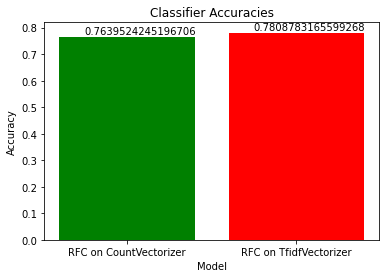

In [145]:
Accuracy=[]
Model=[]
Accuracy.append(randomforestclassifier.score(x_test_main, y_test_main))
Accuracy.append(randomforestclassifier_tf_idf.score(x_test_main_tf_idf, y_test_main_tf_idf))
Model.append("RFC on CountVectorizer")
Model.append("RFC on TfidfVectorizer")


index=[0,1]
plt.bar(index,Accuracy,color=['green', 'red'])
plt.title('Classifier Accuracies')
plt.xticks(index,Model)
plt.ylabel('Accuracy')
plt.xlabel('Model')


for i, v in enumerate(Accuracy):
    plt.text(xlocs[i] - 0.25, v + 0.01, str(v))


## Summary

**RESULTS AND DISCUSSIONS**

1. In this exercise, the dataset contains various tweets based on different airline company services. The “Twitter Airline Sentiment” dataset was downloaded from Kaggle which contains tweets covering six U.S. airline companies with a total number of (14,640) tweets, each of which is labeled according to sentiment polarity as: positive, negative, and neutral.

**Pre-processing steps in NLP**
1. HTML tag cleanup - It returns all the text in a document or beneath a tag, as a single Unicode string:

2. Tokenization: Tokenization is a step which splits longer strings of text into smaller pieces, or tokens.
   Larger chunks of text can be tokenized into sentences, sentences can be tokenized into words, etc. Further   processing is generally performed after a piece of text has been appropriately tokenized.
   Tokenization is also referred to as text segmentation or lexical analysis.
   Sometimes segmentation is used to refer to the breakdown of a large chunk of text into pieces larger than words (e.g. paragraphs or sentences), while tokenization is reserved for the breakdown process which results exclusively in words.
3. Removing numbers - Remove numbers from list of tokenized words
4. Remove special characters - Remove special characters from list of tokenized words
5. Remove punctuation - Remove punctuation from list of tokenized words
6. Convert text to lower case - converting all text to the same case
7. Remove empty strings- Remove empty string from list of tokenized words
8. Stemming- Converting the words into their base word or stem word ( Ex - tastefully, tasty, these words are converted to stem word called 'tasti'). This reduces the vector dimension because we dont consider all similar words
9. Lemmatization - Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

**Techniques for Encoding**
1. Steps to do after text pre-processing: Techniques for Encoding - These are the popular techniques that are used for encoding:
2. Bag of words(CountVectorization): In BoW we construct a dictionary that contains set of all unique words from our text review dataset. The frequency of the word is counted here. If there are d unique words in our dictionary then for every sentence or review the vector will be of length d and count of word from review is stored at its particular location in vector. The vector will be highly sparse in such case. 
3. Tf-idf(TfIdfVectorization)(Term Frequency - Inverse Document Frequency): Term Frequency - Inverse Document Frequency it makes sure that less importance is given to most frequent words and also considers less frequent words.Term Frequency is number of times a particular word(W) occurs in a review divided by totall number of words (Wr) in review. The term frequency value ranges from 0 to 1.
4. Inverse Document Frequency is calculated as log(Total Number of Docs(N) / Number of Docs which contains particular word(n)). Here Docs referred as Reviews.
                        TF-IDF is TF * IDF that is (W/Wr)*LOG(N/n)

**Summary of the above exercise in terms os model performance**

RandomForestClassifier on TfidfVectorizer has an accuracy of 77.8% whereas RandomForestClassifier on CountVectorizer has an accuracy of 76.3%. This shows that the model using TfidfVectorizer is better.
Model is able to predict airline sentiment correctly 77% of the time